In [100]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
from os import listdir
import pandas as pd
import numpy as np
import re
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import KeyedVectors

In [141]:
#loading data
def load_file_to_df(filename):
    df = pd.read_csv(filename,delimiter='\t',header=0)
    df = df.drop(['Unnamed: 0', 'id'],axis=1)
    df_text = df.iloc[:,:1]
    df_score = df.iloc[:,1:]
    return df_text,df_score

In [142]:
headlines_text,headlines_score = load_file_to_df("FiQA_train_ABSA_financial_headlines.tsv")
post_text,post_score = load_file_to_df("FiQA_train_ABSA_financial_posts.tsv")
text = pd.concat([headlines_text,post_text])
score = pd.concat([headlines_score,post_score])

In [143]:
# score

In [144]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [145]:
# extract sentences out of df and cleaning it
sentences = [clean_sentence(x) for x in text['text']]

In [146]:
#converting real number scores to lables
#0-->-ve sentiment 1-->+ve sentiment
score_list = [float(x) for x in score['sentiment score']]
labels_df = (score>=0).astype(int)
labels = [int(x) for x in labels_df['sentiment score']]

In [147]:
#shuffling dataset
numbers = [i for i in range(len(sentences))]
shuffle(numbers)
# numbers

In [148]:
temp_text = sentences
temp_lables = labels
temp_score = score_list
for i in numbers:
    sentences[i] = temp_text[i]
    labels[i]=temp_lables[i]
    score_list[i] = temp_score[i]
print(len(sentences))
print(len(labels))
print(len(score_list))

3789
3789
3789


In [149]:
#doing train and test split
test_train_split_ratio =0.9
trainX,testX = sentences[:int(test_train_split_ratio*len(sentences))],sentences[int(test_train_split_ratio*len(sentences)):]
trainY,testY = labels[:int(test_train_split_ratio*len(labels))],labels[int(test_train_split_ratio*len(labels)):]
score_trainY,score_testY = score_list[:int(test_train_split_ratio*len(score_list))],score_list[int(test_train_split_ratio*len(score_list)):]

In [150]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))
print(len(score_trainY),len(score_testY))

3410 3410
379 379
3410 379


In [151]:
# type(trainY[0])

In [152]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [153]:
# calculate the maximum document length
# def max_length(lines):
#     return max([len(s.split()) for s in lines])

In [154]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [155]:
testLines = [' '.join(x) for x in testX]
trainLines = [' '.join(x) for x in trainX]

In [156]:
# trainY = np.array(trainY)
# testY = np.array(testY)
# type(trainY[0])

In [157]:
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
lengths = [len(s.split()) for s in trainLines]
length = max(lengths)
# length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
print(trainX.shape)

Max document length: 21
Vocabulary size: 6019
(3410, 21)


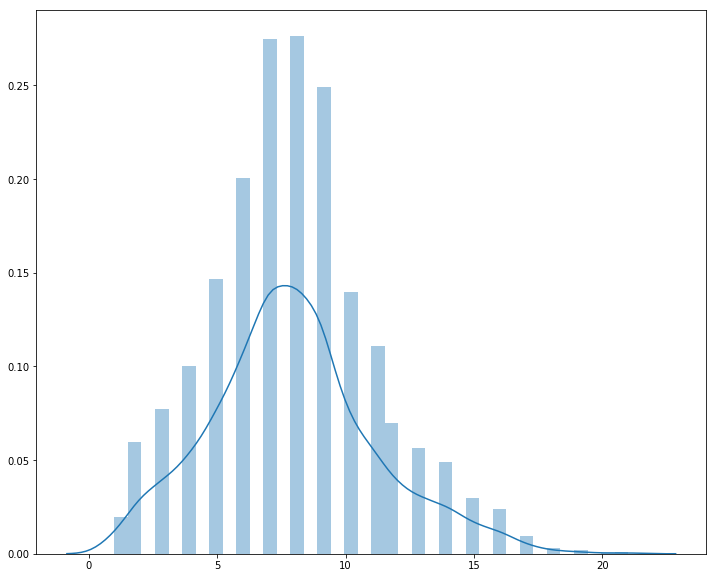

In [158]:
plt.subplots(figsize=(12,10))
sns.distplot(lengths)
# plt.hist(lengths, normed=True,edgecolor='black')

In [66]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [21]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [22]:
embeddings_index_glove = load_GloVe_embedding('glove.6B/glove.6B.300d.txt')
embedding_matrix_glove = get_GloVe_embedding_matrix(embeddings_index_glove)
# embedding_matrix[100]
# e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

Loaded 400000 word vectors.


In [23]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [24]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [25]:
word2vec_model= load_google_word2vec('GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [159]:
#converting output matrix [-ve,+ve]
testY = to_categorical(testY,2)
trainY = to_categorical(trainY,2)

In [160]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 300, weights = [embedding_matrix_glove],input_length=length, trainable=False)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 300, weights = [embedding_matrix_word2vec],input_length=length,trainable=False)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 300)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [161]:
# define model
model = define_model(length, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 21, 300)      1805700     input_10[0][0]                   
__________________________________________________________________________________________________
embedding_

In [162]:
# fit model
history_object = model.fit([trainX,trainX,trainX], trainY,epochs=10, batch_size=16)

Epoch 1/10
3410/3410 [==============================] - 8s 2ms/step - loss: 0.5841 - acc: 0.6795
Epoch 2/10
3410/3410 [==============================] - 8s 2ms/step - loss: 0.2874 - acc: 0.8891
Epoch 3/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.1170 - acc: 0.9645
Epoch 4/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0675 - acc: 0.9721
Epoch 5/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0510 - acc: 0.9748
Epoch 6/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0393 - acc: 0.9774
Epoch 7/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0332 - acc: 0.9815
Epoch 8/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0318 - acc: 0.9795
Epoch 9/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0343 - acc: 0.9801
Epoch 10/10
3410/3410 [==============================] - 7s 2ms/step - loss: 0.0315 - acc: 0.9789


Text(0.5,0,'epoch')

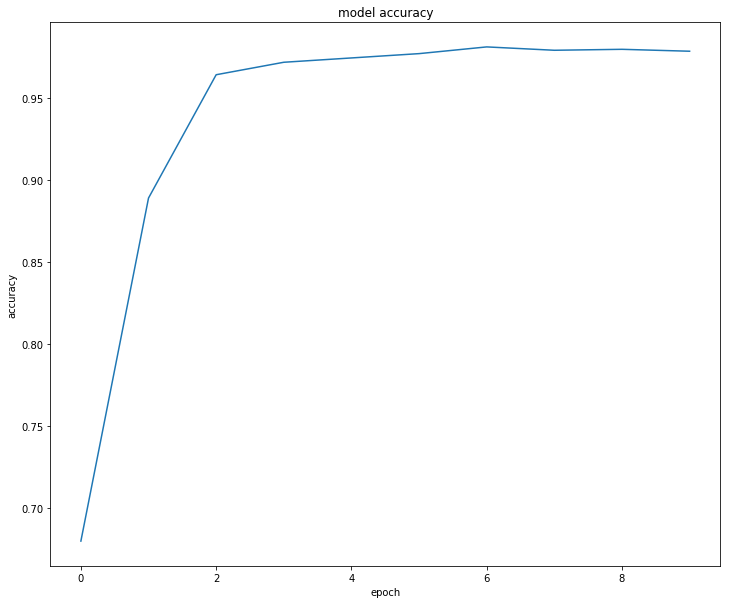

In [163]:
plt.subplots(figsize=(12,10))
plt.plot(history_object.history['acc'])
# plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

Text(0.5,0,'epoch')

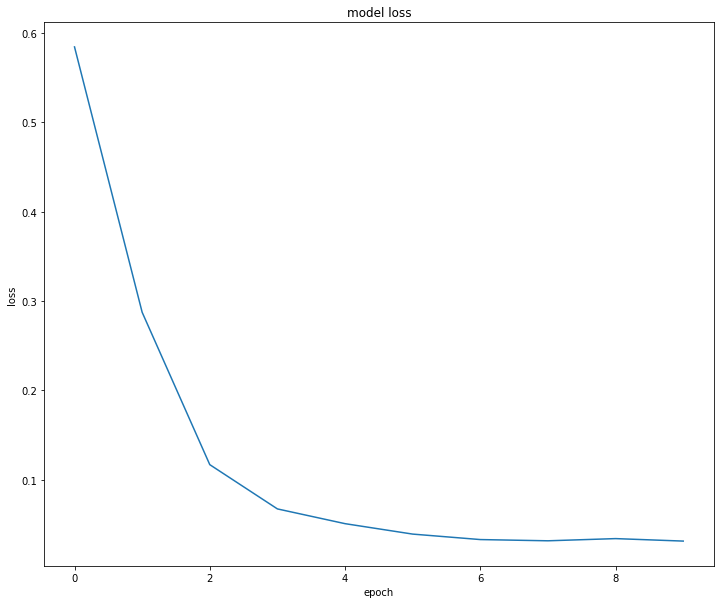

In [164]:
plt.subplots(figsize=(12,10))
plt.plot(history_object.history['loss'])
# plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')

In [165]:
#testing
# encode data
# trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
print(trainX.shape, testX.shape)

(3410, 21) (379, 21)


In [166]:
# evaluate model on training dataset
loss, acc = model.evaluate([trainX,trainX,trainX], trainY, verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX], testY, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 98.299120
Test Accuracy: 83.113456


In [167]:
model.predict([testX,testX,testX])

array([[5.69510367e-03, 9.94304836e-01],
       [6.70962036e-01, 3.29037994e-01],
       [6.89965189e-01, 3.10034811e-01],
       [9.97743368e-01, 2.25666072e-03],
       [9.99930024e-01, 7.00082965e-05],
       [9.88546729e-01, 1.14532048e-02],
       [2.83455383e-02, 9.71654475e-01],
       [6.51870272e-04, 9.99348104e-01],
       [1.49719059e-01, 8.50280941e-01],
       [1.19892005e-02, 9.88010824e-01],
       [1.97078846e-03, 9.98029172e-01],
       [9.71403369e-06, 9.99990344e-01],
       [9.53191996e-01, 4.68080565e-02],
       [3.11271707e-03, 9.96887267e-01],
       [7.19553649e-01, 2.80446351e-01],
       [5.08323193e-01, 4.91676778e-01],
       [1.65960882e-02, 9.83403862e-01],
       [6.61415572e-04, 9.99338567e-01],
       [2.51402176e-04, 9.99748647e-01],
       [6.05232222e-03, 9.93947625e-01],
       [1.78267937e-02, 9.82173204e-01],
       [2.79228777e-01, 7.20771253e-01],
       [2.10577101e-02, 9.78942275e-01],
       [5.89779019e-01, 4.10220981e-01],
       [5.023172

In [128]:
def get_predicted_prob(data):
    return [list(x) for x in model.predict(data)]

In [129]:
#predicted probabilities
train_predicted_prob = get_predicted_prob([trainX,trainX,trainX])
test_predicted_prob = get_predicted_prob([testX,testX,testX])
# predicted_prob

In [130]:
# test_predicted_prob

In [131]:
#predicting lables
#if prob>0.5 -->1 else 0
# def get_predicted_lables(prob):
#     predicted_lables = []
#     for x in prob:
#         if x>0.5:
#             predicted_lables.append(1)
#         else:
#             predicted_lables.append(0)
#     return predicted_lables
def get_predicted_lables(prob):
    predicted_lables = []
    for x in prob:
        if x[0]>x[1]:
            predicted_lables.append(0)
        else:
            predicted_lables.append(1)
    return predicted_lables

In [132]:
train_predicted_lables = get_predicted_lables(train_predicted_prob)
test_predicted_lables = get_predicted_lables(test_predicted_prob)

In [133]:
# train_predicted_lables

In [134]:
# def get_score_from_prob(prob):
#     m = interp1d([0,1],[-1,1])
#     return [float(m(x)) for x in prob]
def get_score_from_prob(prob):
    intensity_score = []
    for x in prob:
        if x[0]>x[1]:
            intensity_score.append(-1*x[0])
        else:
            intensity_score.append(x[1])
    return intensity_score

In [135]:
train_predicted_score = get_score_from_prob(train_predicted_prob)
test_predicted_score = get_score_from_prob(test_predicted_prob)

In [136]:
# test_predicted_score

In [137]:
train_rmse = sqrt(mean_squared_error(score_trainY, train_predicted_score))
test_rmse = sqrt(mean_squared_error(score_testY, test_predicted_score))
print("(train rmse,test rmse)=="+str((train_rmse,test_rmse)))

(train rmse,test rmse)==(0.6550178741071335, 0.7410768949824543)


In [140]:
# foo = [x for x in zip(score_testY,test_predicted_score)]
# foo